# Velocity field comparison between H$_2$CO and H$^{13}$CO$^+$

In [2]:
import numpy as np
from astropy.io import fits
from reproject import reproject_exact
%matplotlib inline
import sys
sys.path.append('../')
from B5setup import *
import matplotlib.pyplot as plt
import aplpy
from scipy import stats
from scipy.integrate import simpson
import os

We first create an H$_2$CO map which shares the same grid as the actual H$^{13}$CO$^+$  image.

H$^{13}$CO$^+$ from van't Hoff et al 2022 has a larger beam (0.61") and pixel size (0.08") than H$_2$CO (beam of 0.41" and pixel size of 0.054"), so we will regrid H$_2$CO to the H$^{13}$CO$^+$ map (but the one that we cut because the original one is too big)

In [3]:
folderH2CO = 'gaussfit_H2CO/analysis_central_chans_masked/'
folderH13COp = '../B5_previous_data/'
h2covlsrfilename = 'components_blueshifted_envelope_vlsr'
h13copvlsrfilename = 'B5-IRS1_H13COp_2_1_short_cut_K_kms_1G_fitparams_2_filtered_Vlsr'
diffdatafile = 'B5_H2CO_blueshifted_envelope_minus_H13COp'

In [5]:
if not os.path.exists(folderH2CO + h2covlsrfilename + '_reprojectH13COp.fits'):
    H2COhdu = fits.open(folderH2CO + h2covlsrfilename + '.fits')
    # key_remove = ['PC03_01', 'PC04_01', 'PC01_03', 'PC02_03', 'PC03_02', 'PC04_02','PC03_03', 'PC04_03', 'PC01_04',
    #               'PC02_04', 'PC03_04', 'PC04_04', 'CUNIT3', 'CRPIX4','CDELT4','CUNIT4','CTYPE4','CRVAL4','SPECSYS']
    # for key_i in key_remove: # there are more dimensions written in the NH3 fits file
    #     NH3hdu[0].header.remove(key_i)
    H13COpheader = fits.getheader(folderH13COp + h13copvlsrfilename + '.fits')
    newH2COimage, footprint = reproject_exact(H2COhdu[0], H13COpheader)
    # now we modify the spatial properties of the H2CO Header
    newheader = H2COhdu[0].header.copy() # we use this header as it has the resolution
    key_modify = ['CUNIT1', 'CRPIX1','CDELT1','CTYPE1','CRVAL1', 'CUNIT2', 'CRPIX2','CDELT2','CTYPE2','CRVAL2']
    for key_i in key_modify: # there are more dimensions written in the NH3 fits file
        newheader[key_i] = H13COpheader[key_i]

    fits.writeto(folderH2CO + h2covlsrfilename + '_reprojectH13COp.fits', newH2COimage, newheader)
    H2COhdu.close()
else:
    newH2COimage = fits.getdata(folderH2CO + h2covlsrfilename + '_reprojectH13COp.fits')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [7]:
H13COpdata = fits.getdata(folderH13COp + h13copvlsrfilename + '.fits')
H13COpheader = fits.getheader(folderH13COp + h13copvlsrfilename + '.fits')

diff = newH2COimage - H13COpdata

newhead = H13COpheader.copy()
newhead.remove('BUNIT')
if not os.path.exists(folderH2CO + diffdatafile + '.fits'):
    fits.writeto(folderH2CO + diffdatafile + '.fits', diff, newhead)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


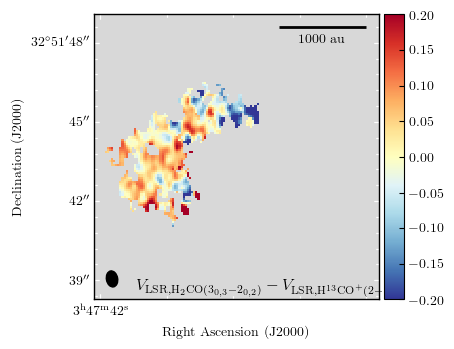

In [8]:
# we plot quickly the difference
fig = plt.figure(figsize=(4,4))
velmin = -0.2
velmax = 0.2
ax = plot_aplpy_subfig(folderH2CO + diffdatafile + '.fits', 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r',barsize=1000)
ax.recenter(ra_yso, dec_yso, 0.0015)
ax.add_label(0.6, 0.04, 
             r'$V_{\mathrm{LSR},\mathrm{H}_2\mathrm{CO}(3_{0,3}-2_{0,2})} - V_{\mathrm{LSR}, \mathrm{H}^{13}\mathrm{CO}^+(2-1)}$', 
             relative=True, family='sans-serif', size=12)
# fig.savefig(folderHC3N + diffdatafile + '.pdf', bbox_inches='tight')

Now we do a statistical estimation if there is significant difference looking at the probability density function obtained from the Kernel Density Estimation

In [9]:
data_kde = np.linspace(-0.4, 0.4, 100)
data = fits.getdata(folderH2CO + diffdatafile + '.fits')
data = data[~np.isnan(data)]
p_range = np.array([0.15865 * 100, 50., 0.84135 * 100]) # I believe this is one sigma? ask Jaime
vlsr_median_unc = np.round(np.percentile(data, p_range), decimals=2)

kernel = stats.gaussian_kde(data)
dens = kernel(data_kde)
dens /= simpson(dens, data_kde) # normalizing of probability

datasave = np.array([data_kde, dens, vlsr_median_unc], dtype=object)
if not os.path.exists(folderH2CO + diffdatafile+'.npy'):
    np.save(folderH2CO + diffdatafile+'.npy', datasave)

Text(-0.030000000000000002, 1.1, '0.02$_{-0.09}^{+0.07}$')

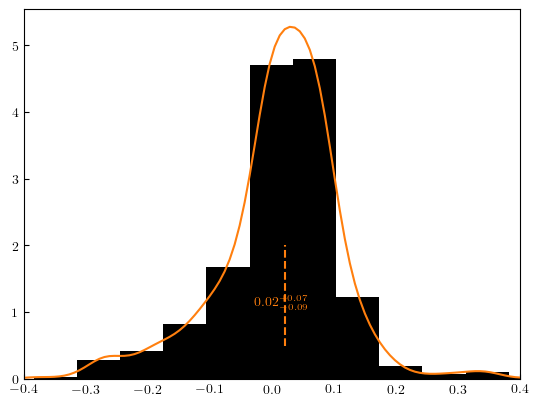

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data, fc='k', bins='sturges', density=True)
ax.plot(data_kde, dens)
ax.set_xlim([-0.4, 0.4])
ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0.5, 2], color='C1', ls='--')
ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10, color='C1')


I am not sure which will be the best way to show the (lack of) difference so we can also try a 2D KDE

In [11]:
# x is v_LSR of H2CO
xmin = 9.2
xmax = 10.6
# y is v_LSR of H13COp
ymin = 9.2
ymax = 10.6
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
# we select only those who are not nan
gd_vlos = np.isfinite(newH2COimage * H13COpdata)
values = np.vstack([newH2COimage[gd_vlos], H13COpdata[gd_vlos]])
# we calculate the kernel distribution
kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()

datasave = np.array([xx, yy, zz])

if not os.path.exists(folderH2CO + diffdatafile+'_2DKDE.npy'):
    np.save(folderH2CO + diffdatafile+'_2DKDE.npy', datasave)

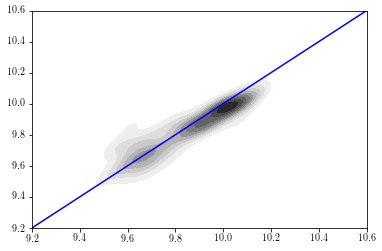

In [9]:
# just to check it quickly
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.plot([9.2, 10.6], [9.2, 10.6], 'b-')